In [23]:
pip install duckdb

Note: you may need to restart the kernel to use updated packages.


In [7]:

import duckdb
import pandas as pd



In [9]:
# importing data 
employment_data = duckdb.read_csv("D:/Python/BNZ MLE/machine-readable-business-employment-data-mar-2024-quarter.csv")   
bis_fin_data = duckdb.read_csv("D:/Python/BNZ MLE/business-financial-data-march-2024-csv.csv")   

duckdb.sql("SELECT * FROM employment_data")
duckdb.sql("SELECT * FROM bis_fin_data")

┌──────────────────┬─────────┬────────────┬────────────┬───┬────────────────┬────────────────┬────────────────┐
│ Series_reference │ Period  │ Data_value │ Suppressed │ … │ Series_title_3 │ Series_title_4 │ Series_title_5 │
│     varchar      │ double  │   double   │  varchar   │   │    varchar     │    varchar     │    varchar     │
├──────────────────┼─────────┼────────────┼────────────┼───┼────────────────┼────────────────┼────────────────┤
│ BDCQ.SF1AA2CA    │ 2016.06 │   1116.386 │ NULL       │ … │ Current prices │ Unadjusted     │ NULL           │
│ BDCQ.SF1AA2CA    │ 2016.09 │   1070.874 │ NULL       │ … │ Current prices │ Unadjusted     │ NULL           │
│ BDCQ.SF1AA2CA    │ 2016.12 │   1054.408 │ NULL       │ … │ Current prices │ Unadjusted     │ NULL           │
│ BDCQ.SF1AA2CA    │ 2017.03 │   1010.665 │ NULL       │ … │ Current prices │ Unadjusted     │ NULL           │
│ BDCQ.SF1AA2CA    │ 2017.06 │     1233.7 │ NULL       │ … │ Current prices │ Unadjusted     │ NULL     

In [298]:
# Question 1
# find industries that dont have wage data did not exist in 2016 and only appeared later

industries_2016 = duckdb.sql("""
    SELECT DISTINCT series_title_2
    FROM employment_data 
    WHERE "group" = 'Industry by employment variable' 
    AND CAST(SUBSTRING(CAST(period AS TEXT), 1, 4) AS INTEGER) = 2016 and data_value is null
""")

industries_before_2016 = duckdb.sql("""
    SELECT DISTINCT series_title_2
    FROM employment_data 
    WHERE "group" = 'Industry by employment variable' 
    AND CAST(SUBSTRING(CAST(period AS TEXT), 1, 4) AS INTEGER) < 2016 and data_value is null
""")

industries_after_2016 = duckdb.sql("""
    SELECT DISTINCT series_title_2
    FROM employment_data 
    WHERE "group" = 'Industry by employment variable' 
    AND CAST(SUBSTRING(CAST(period AS TEXT), 1, 4) AS INTEGER) > 2016 and data_value is null
""")


find_industries_w_data_after_2016 = duckdb.sql("""
    SELECT a.series_title_2
    FROM industries_after_2016 a
    LEFT JOIN industries_2016 b
    ON a.series_title_2 = b.series_title_2
    LEFT JOIN industries_before_2016 c
    ON a.series_title_2 = c.series_title_2
    WHERE b.series_title_2 IS NULL
    AND c.series_title_2 IS NULL
""")

print(find_industries_w_data_after_2016)

┌────────────────┐
│ Series_title_2 │
│    varchar     │
├────────────────┤
│     0 rows     │
└────────────────┘



In [213]:
# Question 1

# we need to find the industries that only appeared after 2016

industries_2016 = duckdb.sql('''
    SELECT DISTINCT Series_title_2 
    FROM employment_data 
    WHERE period <= 2016.12 and  "group" = \'Industry by employment variable\'  
''')

print(industries_2016)

industries_after_2016 = duckdb.sql('''
    SELECT DISTINCT Series_title_2 
    FROM employment_data 
    WHERE period > 2016.12  and "group" = \'Industry by employment variable\'
''')

print(industries_after_2016)

new_industries = duckdb.sql('''
    SELECT DISTINCT Series_title_2 
    FROM employment_data 
    WHERE period > 2016.12 and "group" = \'Industry by employment variable\'
    AND Series_title_2 NOT IN (
        SELECT DISTINCT Series_title_2 
        FROM employment_data 
        WHERE period <= 2016.12 and "group" = \'Industry by employment variable\'
    )
''')

print(new_industries)


┌─────────────────────────────────────────────────┐
│                 Series_title_2                  │
│                     varchar                     │
├─────────────────────────────────────────────────┤
│ Other Services                                  │
│ Mining                                          │
│ Education and Training                          │
│ Information Media and Telecommunications        │
│ Health Care and Social Assistance               │
│ Arts and Recreation Services                    │
│ Total Industry                                  │
│ Construction                                    │
│ Public Administration and Safety                │
│ Transport, Postal and Warehousing               │
│ Financial and Insurance Services                │
│ Professional, Scientific and Technical Services │
│ Administrative and Support Services             │
│ Electricity, Gas, Water and Waste Services      │
│ Wholesale Trade                                 │
│ Retail Tra

In [336]:
#Question2 

Question2 = duckdb.sql('''
    SELECT 
        series_title_2
            ,period
            ,sum(data_value)
    FROM 
        bis_fin_data 
    WHERE  "group" = \'Industry by financial variable (NZSIOC Level 2)\'
        and series_title_1 =\'Sales (operating income)\'
        and series_title_4 = 'Seasonally adjusted'
    group by series_title_2
            ,period
    order by 3 desc

''')

print(Question2)


# Wholesale Trade  & year combination was   2023/03  with a total income sales of   38810.022

┌─────────────────────────────────┬─────────┬─────────────────┐
│         Series_title_2          │ Period  │ sum(data_value) │
│             varchar             │ double  │     double      │
├─────────────────────────────────┼─────────┼─────────────────┤
│ Wholesale Trade                 │ 2022.12 │       39082.893 │
│ Wholesale Trade                 │ 2023.03 │       38810.022 │
│ Wholesale Trade                 │ 2022.09 │       38626.435 │
│ Wholesale Trade                 │ 2023.09 │       38393.837 │
│ Wholesale Trade                 │ 2023.06 │       38382.333 │
│ Wholesale Trade                 │ 2024.03 │       38327.575 │
│ Wholesale Trade                 │ 2023.12 │       38033.182 │
│ Wholesale Trade                 │ 2022.06 │       37658.277 │
│ Wholesale Trade                 │ 2022.03 │       34923.942 │
│ Wholesale Trade                 │ 2021.12 │       33858.214 │
│      ·                          │    ·    │              ·  │
│      ·                          │    ·

In [57]:
#Question 3

# convert period into date format
employment_data_2=duckdb.sql(""" select * 
            , CAST(CONCAT(SUBSTR(CAST(Period AS VARCHAR), 1, 4), '-',
                   CASE
                       WHEN SUBSTR(CAST(Period AS VARCHAR), 6, 2) = '03' THEN '03'
                       WHEN SUBSTR(CAST(Period AS VARCHAR), 6, 2) = '06' THEN '06'
                       WHEN SUBSTR(CAST(Period AS VARCHAR), 6, 2) = '09' THEN '09'
                       WHEN SUBSTR(CAST(Period AS VARCHAR), 6, 2) = '12' THEN '12'
                   END, '-01') AS DATE) AS year_month
from employment_data""")

# get highest average TA for the region 

highestavgTA = duckdb.sql("""
    SELECT 
        series_title_2
        ,avg(data_value) AS AvgFilledJobs
    FROM employment_data_2
    where series_title_1 in ('Filled jobs','Filled jobs (workplace location based)') and "group" = \'Territorial authority by employment variable\'
    and series_title_3 = 'Actual'
    group by 1 
    order by 2 desc
    limit 1
""")

print(highestavgTA)
# auckland has highest average value of filled jobs across time


#create table with cumulative sums of highest region
auckland_quarterly_totals = duckdb.sql("""
SELECT a.year_month,
        (SELECT SUM(b.data_value)
        FROM employment_data_2 b
        WHERE b.year_month <= a.year_month and series_title_1 in ('Filled jobs','Filled jobs (workplace location based)')
        and "group" = \'Territorial authority by employment variable\' and series_title_2 = 'Auckland'
         and series_title_3 = 'Actual'   ) AS cumulative_sum
FROM employment_data_2 a
where series_title_1 in ('Filled jobs','Filled jobs (workplace location based)') and series_title_3 = 'Actual' and "group" = \'Territorial authority by employment variable\' and series_title_2 = 'Auckland'
group by 1
ORDER BY a.year_month; """)


print(auckland_quarterly_totals)
# duckdb.sql("SELECT * FROM employment_data2 limit 10")

┌────────────────┬───────────────────┐
│ Series_title_2 │   AvgFilledJobs   │
│    varchar     │      double       │
├────────────────┼───────────────────┤
│ Auckland       │ 686056.4519230769 │
└────────────────┴───────────────────┘

┌────────────┬────────────────┐
│ year_month │ cumulative_sum │
│    date    │     double     │
├────────────┼────────────────┤
│ 2011-06-01 │      1134578.0 │
│ 2011-09-01 │      2284407.0 │
│ 2011-12-01 │      3451340.0 │
│ 2012-03-01 │      4591262.0 │
│ 2012-06-01 │      5759042.0 │
│ 2012-09-01 │      6924177.0 │
│ 2012-12-01 │      8104705.0 │
│ 2013-03-01 │      9274687.0 │
│ 2013-06-01 │     10472754.0 │
│ 2013-09-01 │     11664993.0 │
│     ·      │          ·     │
│     ·      │          ·     │
│     ·      │          ·     │
│ 2021-12-01 │     57136472.0 │
│ 2022-03-01 │     58656003.0 │
│ 2022-06-01 │     60188724.0 │
│ 2022-09-01 │     61726453.0 │
│ 2022-12-01 │     63302172.0 │
│ 2023-03-01 │     64883781.0 │
│ 2023-06-01 │     66495800.0

In [620]:
#Question 4
# Data Validation:

# Schema Validation:

# Ensure the incoming data adheres to the expected schema, including correct data types,
# required fields, and value ranges.
# one key example that comes to mind is the fixing the date column called period to become a date format

# Data Type Conversion: Automatically convert data types to the expected formats, such as converting strings to dates, numbers, or categorical variables where appropriate.
# Handling Duplicates:

# Duplicate Detection and Removal: Identify and remove duplicate records based on unique identifiers or a combination of fields. 
#You can use methods like drop_duplicates() in Pandas.


# Missing Value Imputation: Identify missing values and apply imputation techniques such as mean/mode/median imputation, forward/backward filling, or using predictive models to estimate missing values.
# Missing Data Indicators: Add indicators or flags for missing data that might need further attention downstream in the pipeline. 
#an example of missing data in this scenario was the 2016 data for wages and salaries

# Date Validation and Handling:

# Date Parsing and Formatting: Ensure date fields are correctly parsed and formatted. Handle invalid dates or incorrect formats by either correcting them or flagging them for review.
# Date Range Validation: Ensure dates fall within expected ranges (e.g., not in the future if not applicable).
# Outlier Detection:

# Outlier Identification: Use statistical methods or domain-specific rules to identify outliers that may indicate data entry errors or significant deviations from expected values.
# Outlier Handling: Decide on an appropriate action for outliers, such as capping, removing, or flagging them.
# Automated Testing and Monitoring:

# Data Quality Checks: Implement automated tests that run during the data ingestion process to check for common data quality issues.
# Monitoring and Alerts: Set up monitoring and alerts for any data quality issues that might arise, so they can be addressed promptly.
# Logging and Auditing:


# Data Standardization: Standardize categorical values, text fields, and other non-numeric data to ensure consistency.
#fields such as filled jobs had either filled jobs or Filled jobs (workplace location based) 


#flattening out dataset to pull what you're wanting
#both datasets have had multiple rows over different fields i.e series_title_2 had TA region as well as industry
#when widening this data, to have a region or a industry column this can make it easier to work with the data to produce insights more easily

# Data Enrichment: Enhance the data with additional information if required, such as deriving new fields or merging with external datasets for more context.

In [131]:
#Question 5

# building a time series model on employment by industry


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

employment_df = employment_data_2.df()

employment_df.set_index('year_month', inplace=True)


emp_df = employment_df[employment_df['Group']=='Industry by employment variable']


emp_df2 = emp_df[emp_df['Series_title_1']=='Filled jobs']
emp_df3 = emp_df2[emp_df2['Series_title_2'] =='Agriculture, Forestry and Fishing']
emp_df4 = emp_df3[emp_df3['Series_title_3'] =='Actual']
print(emp_df4)



           Series_reference   Period  Data_value Suppressed STATUS   UNITS  \
year_month                                                                   
2011-06-01      BDCQ.SEA1AA  2011.06     80078.0       None      F  Number   
2011-09-01      BDCQ.SEA1AA  2011.09     78324.0       None      F  Number   
2011-12-01      BDCQ.SEA1AA  2011.12     85850.0       None      F  Number   
2012-03-01      BDCQ.SEA1AA  2012.03     90743.0       None      F  Number   
2012-06-01      BDCQ.SEA1AA  2012.06     81780.0       None      F  Number   
2012-09-01      BDCQ.SEA1AA  2012.09     79261.0       None      F  Number   
2012-12-01      BDCQ.SEA1AA  2012.12     87793.0       None      F  Number   
2013-03-01      BDCQ.SEA1AA  2013.03     91571.0       None      F  Number   
2013-06-01      BDCQ.SEA1AA  2013.06     81687.0       None      F  Number   
2013-09-01      BDCQ.SEA1AA  2013.09     81471.0       None      F  Number   
2013-12-01      BDCQ.SEA1AA  2013.12     93950.0       None     

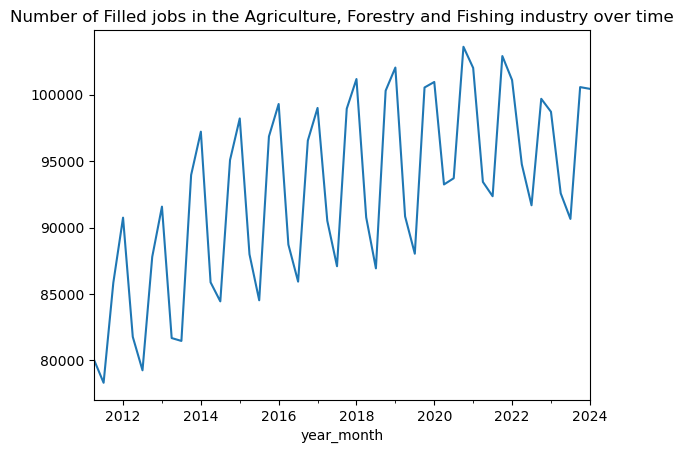

In [133]:

# # Plot the data
emp_df4['Data_value'].plot()
plt.title('Number of Filled jobs in the Agriculture, Forestry and Fishing industry over time')
plt.show()


In [135]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(emp_df4['Data_value'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# found there is likelihood of non stationarity which would be bad for modelling 

ADF Statistic: -2.643997616802149
p-value: 0.08424045435259048


ADF Statistic: -3.0213871451692733
p-value: 0.032944808995601614


<Axes: xlabel='year_month'>

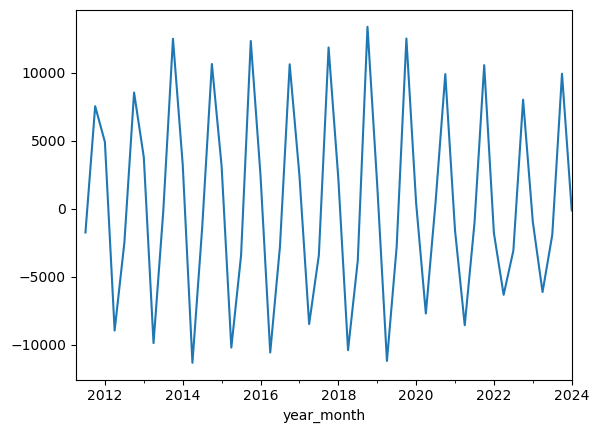

In [137]:


result2 = adfuller(emp_df4['Data_value'].diff().dropna())
print('ADF Statistic:', result2[0])
print('p-value:', result2[1])

emp_df4['Data_value'].diff().plot()
# stationarity achieved as  shown through graph

In [139]:
#splitting data into training and test

train_size = int(len(emp_df4) * 0.8)
train, test = emp_df4[:train_size], emp_df4[train_size:]

print(train)

           Series_reference   Period  Data_value Suppressed STATUS   UNITS  \
year_month                                                                   
2011-06-01      BDCQ.SEA1AA  2011.06     80078.0       None      F  Number   
2011-09-01      BDCQ.SEA1AA  2011.09     78324.0       None      F  Number   
2011-12-01      BDCQ.SEA1AA  2011.12     85850.0       None      F  Number   
2012-03-01      BDCQ.SEA1AA  2012.03     90743.0       None      F  Number   
2012-06-01      BDCQ.SEA1AA  2012.06     81780.0       None      F  Number   
2012-09-01      BDCQ.SEA1AA  2012.09     79261.0       None      F  Number   
2012-12-01      BDCQ.SEA1AA  2012.12     87793.0       None      F  Number   
2013-03-01      BDCQ.SEA1AA  2013.03     91571.0       None      F  Number   
2013-06-01      BDCQ.SEA1AA  2013.06     81687.0       None      F  Number   
2013-09-01      BDCQ.SEA1AA  2013.09     81471.0       None      F  Number   
2013-12-01      BDCQ.SEA1AA  2013.12     93950.0       None     

In [165]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the model with chosen parameters (p, d, q) and seasonal parameters (P, D, Q, m)
model = SARIMAX(train['Data_value'], order=(1, 1, 0), seasonal_order=(1, 1, 1, 24))
model_fit = model.fit()

E:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
E:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
E:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [167]:
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           Data_value   No. Observations:                   41
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 24)   Log Likelihood                -149.145
Date:                              Mon, 02 Sep 2024   AIC                            306.290
Time:                                      01:29:24   BIC                            309.380
Sample:                                  06-01-2011   HQIC                           306.448
                                       - 06-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0170      0.186      0.091      0.927      -0.347       0.381
ar.S.L24      -0.00

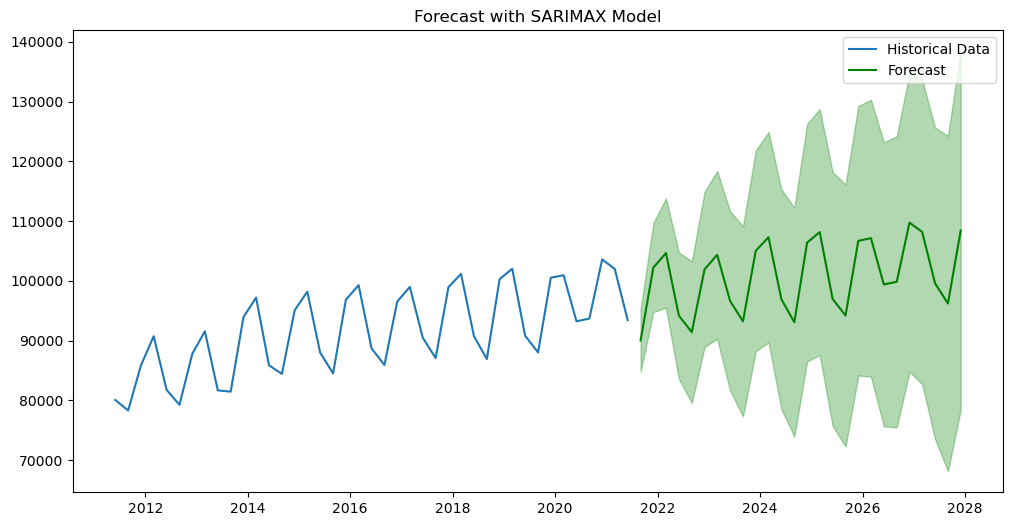

In [205]:
forecast_steps = 26  # Number of steps to forecast
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Data_value'], label='Historical Data')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_mean.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='green', alpha=0.3)
plt.legend()
plt.title('Forecast with SARIMAX Model')
plt.show()

#for very little data the model shows some promise in forecasting


#I performed a time series analysis because the data I had worked with was employment data over time,so I decided to focus on one industry (aggri business) 
#and look into how I can forceast it into the next quarters 

#I chose the SARIMAX model because in my mind there was a seasonality component once visualizing the data
# and so this model felt like the best choice to help predict jobs filled in the future

In [197]:
# Forecast with the model
forecast = arima_fit.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
mae = mean_absolute_error(test['Data_value'], forecast_mean)
mse = mean_squared_error(test['Data_value'], forecast_mean)
rmse = mse ** 0.5


print(f'ARIMA MAE: {mae}')
print(f'ARIMA MSE: {mse}')
print(f'ARIMA RMSE: {rmse}')


ARIMA MAE: 4551.463566876052
ARIMA MSE: 28804892.632585015
ARIMA RMSE: 5367.018970768132
